In [35]:
import sys
import os
import time

SCRIPT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(SCRIPT_DIR)

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tueplots import bundles, figsizes

from bocpd import bocpd
from hazard import ConstantHazard
from models import DSMGaussian
from models import Gaussian
from utils.find_cp import find_cp

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [36]:
RESULT_PATH = os.path.join(SCRIPT_DIR,'notebooks/results/extras')

In [37]:
np.random.seed(12345)

T = 600
data = np.zeros((T,1))
cps = [200, 400, 600]
mus = [10, 0, 10]
vars = [1, 1, 1]
i = 0
mu = mus[0]
var = vars[0]
for t in range(0, T):
    if t == cps[i]:
        mu = mus[i+1]
        var = vars[i+1]
        i = i+1
    data[t,0] = np.random.normal(mu, var)

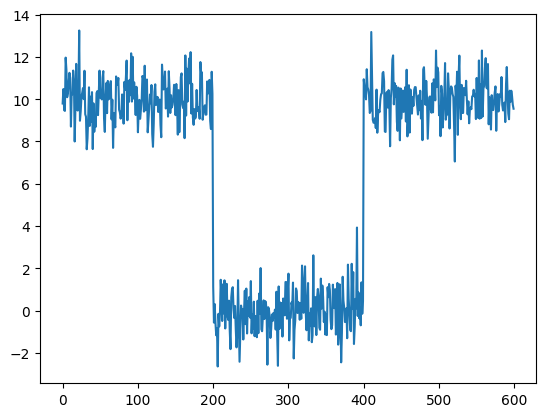

In [38]:
plt.plot(data)

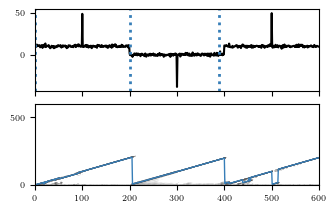

In [39]:
np.random.seed(12345)
i_cont = [100,300,500]
j = np.array([1,-1,1])
Rs_DSM = []
Rs_SM = []
Rs_ST = []

cps_DSM = []
cps_SM = []
cps_ST = []

datasets_contaminated =[]

for k in [40]:
    data_contaminated = data.copy()
    data_contaminated[i_cont,0] = data_contaminated[i_cont,0] + j*k

    mean0 = np.mean(data_contaminated)
    var0 = np.var(data_contaminated)

    mean_mu0 = 5
    var_mu0 = 10

    mean_Sigma0 = 1
    var_Sigma0 = 1

    mu0 = np.array([[mean_mu0/var_mu0], [1/var_mu0]])

    Sigma0 = np.eye(2)
    Sigma0[0,0] = mean_Sigma0/var_Sigma0
    Sigma0[1,1] = 1/var_Sigma0

    ###### ROBUST 
    def m(x):
        return np.array([(1+x**2)**(-1/2)])

    def grad_m(x):
        return np.array([[-x/((1+x**2)**(3/2))]])

    model  = DSMGaussian(data=data_contaminated, m=m, grad_m=grad_m, omega=0.03, mu0=mu0, Sigma0=Sigma0)
    hazard = ConstantHazard(300)
    R_DSM = bocpd(data_contaminated, hazard, model)
    cp_DSM = find_cp(R_DSM)


    FILE_NAME = 'Varying_{}.pdf'.format(k)
    with plt.rc_context(bundles.icml2022()):
        fig, ax = plt.subplots(2, 1, sharex = True)
        ax[0].plot(data_contaminated, c= 'k')
        ax[0].set_xlim([0, T])
        y_lims = ax[0].get_ylim()

        ax[1].imshow(np.rot90(R_DSM), aspect='auto', cmap='gray_r', 
                        norm=LogNorm(vmin=0.0001, vmax=1), extent=[0, T, 0, T])
        ax[1].plot(np.argmax(R_DSM,axis=1), c=CB_color_cycle[0], alpha=1, lw=1)

        for cp in cp_DSM:
            ax[0].axvline(cp, c=CB_color_cycle[0], lw=2, ls='dotted')

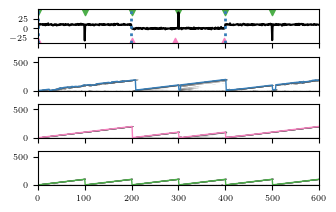

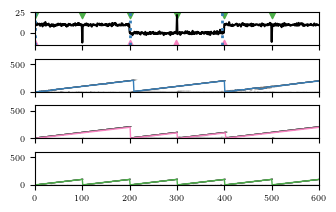

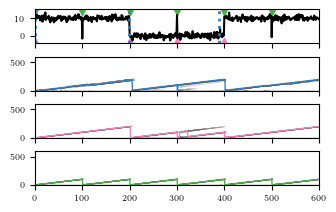

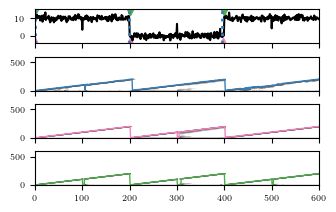

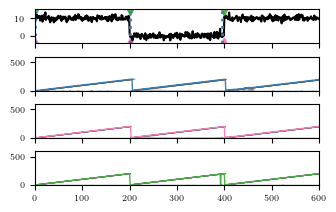

In [40]:
np.random.seed(123)
i_cont = [100,300,500]
j = np.array([-1,1,-1])
Rs_DSM = []
Rs_SM = []
Rs_ST = []

cps_DSM = []
cps_SM = []
cps_ST = []

datasets_contaminated =[]

for epsilon in [40, 20, 10, 5, 0]:
    data_contaminated = data.copy()
    data_contaminated[i_cont,0] = data_contaminated[i_cont,0] + j*epsilon

    omega = 0.03

    mean0 = np.mean(data_contaminated)
    var0 = np.var(data_contaminated)

    mean_mu0 = 5
    var_mu0 = 10

    mean_Sigma0 = 1
    var_Sigma0 = 1

    mu0 = np.array([[mean_mu0/var_mu0], [1/var_mu0]])

    Sigma0 = np.eye(2)
    Sigma0[0,0] = mean_Sigma0/var_Sigma0
    Sigma0[1,1] = 1/var_Sigma0

    ###### ROBUST 
    def m(x):
        return np.array([(1+x**2)**(-1/2)])

    def grad_m(x):
        return np.array([[-x/((1+x**2)**(3/2))]])

    model  = DSMGaussian(data=data_contaminated, m=m, grad_m=grad_m, omega=omega, mu0=mu0, Sigma0=Sigma0)
    hazard = ConstantHazard(300)
    R_DSM = bocpd(data_contaminated, hazard, model)
    cp_DSM = find_cp(R_DSM)

    ### Standard

    model  = Gaussian(mu0=5, kappa0=1, alpha0=1, omega0=1)
    hazard = ConstantHazard(300)
    R_standard = bocpd(data_contaminated, hazard, model)
    cp_standard = find_cp(R_standard)

    ## NON ROBUST


    def m(x):
        return np.eye(1)

    def grad_m(x):
        return np.zeros((1,1,1))
        
    model  = DSMGaussian(data=data_contaminated, m=m, grad_m=grad_m, omega=omega, mu0=mu0, Sigma0=Sigma0)
    hazard = ConstantHazard(300)
    R_SM = bocpd(data_contaminated, hazard, model)
    cp_SM = find_cp(R_SM)

    Rs_DSM.append(R_DSM)
    Rs_SM.append(R_SM)
    Rs_ST.append(R_standard)

    cps_DSM.append(cp_DSM)
    cps_SM.append(cp_SM)
    cps_ST.append(cp_standard)

    datasets_contaminated.append(data_contaminated)

    FILE_NAME = 'Varying_epsilon_{}.pdf'.format(epsilon)
    with plt.rc_context(bundles.icml2022()):
        fig, ax = plt.subplots(4, 1, sharex = True)
        ax[0].plot(data_contaminated, c= 'k')
        ax[0].set_xlim([0, T])
        y_lims = ax[0].get_ylim()

        ax[1].imshow(np.rot90(R_DSM), aspect='auto', cmap='gray_r', 
                        norm=LogNorm(vmin=0.0001, vmax=1), extent=[0, T, 0, T])
        ax[1].plot(np.argmax(R_DSM,axis=1), c=CB_color_cycle[0], alpha=1, lw=1)

        for cp in cp_DSM:
            ax[0].axvline(cp, c=CB_color_cycle[0], lw=2, ls='dotted')

        ax[2].imshow(np.rot90(R_SM), aspect='auto', cmap='gray_r', 
                        norm=LogNorm(vmin=0.0001, vmax=1), extent=[0, T, 0, T])
        ax[2].plot(np.argmax(R_SM,axis=1), c=CB_color_cycle[3], alpha=1, lw=1)

        for cp in cp_SM:
            ax[0].scatter(cp, y_lims[0],c=CB_color_cycle[3], marker="^")
            
        ax[3].imshow(np.rot90(R_standard), aspect='auto', cmap='gray_r', 
                        norm=LogNorm(vmin=0.0001, vmax=1), extent=[0, T, 0, T])
        ax[3].plot(np.argmax(R_standard,axis=1), c=CB_color_cycle[2], alpha=1, lw=1)

        for cp in cp_standard:
            ax[0].scatter(cp, y_lims[1],c=CB_color_cycle[2], marker="v")
        
        fig.savefig(os.path.join(RESULT_PATH, FILE_NAME), format="pdf", bbox_inches= "tight")

        

Rs_DSM.reverse()
Rs_SM.reverse()
Rs_ST.reverse()

cps_DSM.reverse()
cps_SM.reverse()
cps_ST.reverse()
datasets_contaminated.reverse()

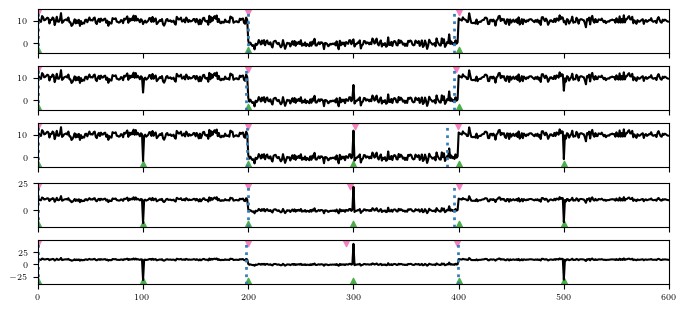

In [41]:
FILE_NAME = 'Varying_epsilon.pdf'
with plt.rc_context(bundles.icml2022()):
    fig, ax = plt.subplots(len(cps_DSM), 1, sharex = True, figsize=(6.75,3))
    for i in range(len(cps_DSM)):
        ax[i].plot(datasets_contaminated[i], c= 'k')
        ax[i].set_xlim([0, T])
        y_lims = ax[i].get_ylim()
        for cp in cps_DSM[i]:
            ax[i].axvline(cp, c=CB_color_cycle[0], lw=2, ls='dotted')

        for cp in cps_SM[i]:
            ax[i].scatter(cp, y_lims[1],c=CB_color_cycle[3], marker="v")

        for cp in cps_ST[i]:
            ax[i].scatter(cp, y_lims[0],c=CB_color_cycle[2], marker="^")
        
        fig.savefig(os.path.join(RESULT_PATH, FILE_NAME), format="pdf", bbox_inches= "tight")

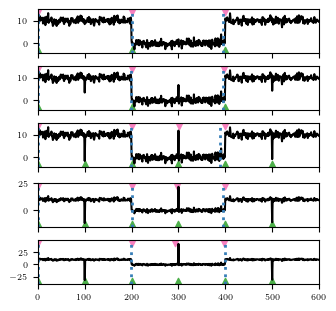

In [63]:
FILE_NAME = 'Varying_epsilon_col.pdf'
with plt.rc_context(bundles.icml2022()):
    fig, ax = plt.subplots(len(cps_DSM), 1, sharex = True, figsize=(3.25,3))
    for i in range(len(cps_DSM)):
        ax[i].plot(datasets_contaminated[i], c= 'k')
        ax[i].set_xlim([0, T])
        y_lims = ax[i].get_ylim()
        for cp in cps_DSM[i]:
            ax[i].axvline(cp, c=CB_color_cycle[0], lw=2, ls='dotted')

        for cp in cps_SM[i]:
            ax[i].scatter(cp, y_lims[1],c=CB_color_cycle[3], marker="v")

        for cp in cps_ST[i]:
            ax[i].scatter(cp, y_lims[0],c=CB_color_cycle[2], marker="^")
        
        fig.savefig(os.path.join(RESULT_PATH, FILE_NAME), format="pdf", bbox_inches= "tight")

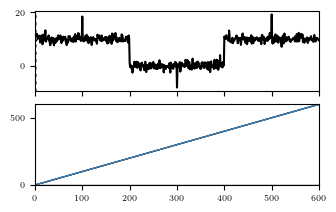

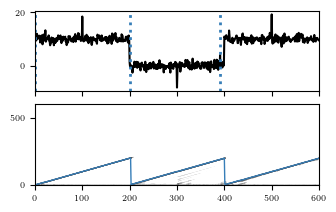

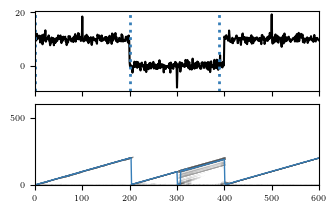

In [45]:
np.random.seed(12345)
i_cont = [100,300,500]
j = np.array([1,-1,1])
epsilon = 10
times = []
R_DSM_k = []
cp_DSM_k = []
for k in [1, 50, T]:
    data_contaminated = data.copy()
    data_contaminated[i_cont,0] = data_contaminated[i_cont,0] + j*epsilon

    mean0 = np.mean(data_contaminated)
    var0 = np.var(data_contaminated)

    mean_mu0 = 5
    var_mu0 = 5

    mean_Sigma0 = 1
    var_Sigma0 = 1

    mu0 = np.array([[mean_mu0/var_mu0], [1/var_mu0]])

    Sigma0 = np.eye(2)
    Sigma0[0,0] = mean_Sigma0/var_Sigma0
    Sigma0[1,1] = 1/var_Sigma0

    ###### ROBUST 
    def m(x):
        return np.array([(1+x**2)**(-1/2)])

    def grad_m(x):
        return np.array([[-x/((1+x**2)**(3/2))]])
    
    start_time = time.time()
    model  = DSMGaussian(data=data_contaminated, m=m, grad_m=grad_m, omega=0.1, mu0=mu0, Sigma0=Sigma0)
    hazard = ConstantHazard(300)
    R_DSM = bocpd(data_contaminated, hazard, model, K=k)
    end_time = time.time()
    cp_DSM = find_cp(R_DSM)

    times.append(end_time-start_time)
    R_DSM_k.append(R_DSM)
    cp_DSM_k.append(cp_DSM)

    FILE_NAME = 'Varying_k_{}.pdf'.format(k)
    with plt.rc_context(bundles.icml2022()):
        fig, ax = plt.subplots(2, 1, sharex = True)
        ax[0].plot(data_contaminated, c= 'k')
        ax[0].set_xlim([0, T])
        y_lims = ax[0].get_ylim()

        ax[1].imshow(np.rot90(R_DSM), aspect='auto', cmap='gray_r', 
                        norm=LogNorm(vmin=0.0001, vmax=1), extent=[0, T, 0, T])
        ax[1].plot(np.argmax(R_DSM,axis=1), c=CB_color_cycle[0], alpha=1, lw=1)

        for cp in cp_DSM:
            ax[0].axvline(cp, c=CB_color_cycle[0], lw=2, ls='dotted')
            
    fig.savefig(os.path.join(RESULT_PATH, FILE_NAME), format="pdf", bbox_inches= "tight")
            

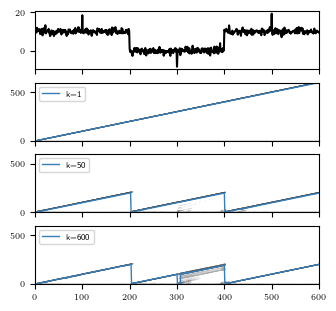

In [59]:
k = [1, 50, T]
FILE_NAME = 'Varying_k_col.pdf'
with plt.rc_context(bundles.icml2022()):
    fig, ax = plt.subplots(4, 1, sharex = True, figsize=(3.25,3))
    ax[0].plot(data_contaminated, c= 'k')
    ax[0].set_xlim([0, T])
    y_lims = ax[0].get_ylim()
    for i in range(len(R_DSM_k)):
        ax[i+1].imshow(np.rot90(R_DSM_k[i]), aspect='auto', cmap='gray_r', 
                        norm=LogNorm(vmin=0.0001, vmax=1), extent=[0, T, 0, T])
        ax[i+1].plot(np.argmax(R_DSM_k[i],axis=1), c=CB_color_cycle[0], alpha=1, lw=1, label= 'k={}'.format(k[i]))
        ax[i+1].legend(loc=2)
        
    fig.savefig(os.path.join(RESULT_PATH, FILE_NAME), format="pdf", bbox_inches= "tight")

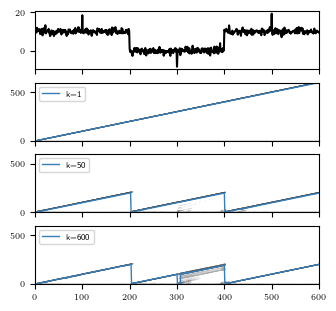

In [60]:
k = [1, 50, T]
FILE_NAME = 'Varying_k_full.pdf'
with plt.rc_context(bundles.icml2022()):
    fig, ax = plt.subplots(4, 1, sharex = True, figsize=(3.25,3))
    ax[0].plot(data_contaminated, c= 'k')
    ax[0].set_xlim([0, T])
    y_lims = ax[0].get_ylim()
    for i in range(len(R_DSM_k)):
        ax[i+1].imshow(np.rot90(R_DSM_k[i]), aspect='auto', cmap='gray_r', 
                        norm=LogNorm(vmin=0.0001, vmax=1), extent=[0, T, 0, T])
        ax[i+1].plot(np.argmax(R_DSM_k[i],axis=1), c=CB_color_cycle[0], alpha=1, lw=1, label= 'k={}'.format(k[i]))
        ax[i+1].legend(loc=2)
        
    fig.savefig(os.path.join(RESULT_PATH, FILE_NAME), format="pdf", bbox_inches= "tight")

In [61]:
times

[1.6121108531951904, 38.365288734436035, 236.8184471130371]